In [1]:
%matplotlib inline

import sys
sys.path.append('/storage2/andrey/code/vrAnalysis/')

import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from scipy.signal import savgol_filter
from scipy.stats import gaussian_kde
from scipy import stats as scipystats
from scipy import signal, interpolate
from scipy.interpolate import interp1d
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from functools import reduce

from analysis.plots.utils import get_colors
from analysis.processing.utils import get_sessions_list, create_symlinks, get_params_from_json
from analysis.processing.metrics import get_fields_between_epochs, get_lonely_fields
from analysis.adapters.hdf5 import H5NAMES
from analysis.processing.epochs import get_epochs
from analysis.plots.utils import get_figure_size, get_extent
from analysis.models.analytics import gaussian_kernel_2D

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
def get_trajectory_in_arena_rf(h5file):
    with h5py.File(h5file, 'r') as f:
        trajectory = np.array(f['animal_trajectory'])
        arena_trajectory = np.array(f['arena_trajectory'])

    # bring to arena coordinate system
    a_min, a_max = arena_trajectory[:, 2].min(), arena_trajectory[:, 2].max()
    arena_trajectory[:, 2] -= a_min
    trajectory[:, 2] -= arena_trajectory[:len(trajectory), 2] - ( (a_max - a_min)/2 )
    
    return trajectory

In [3]:
def get_occ_and_speed(sessions_list, bin_size=0.03):
    # get a session for common variables
    animal, session = sessions_list[0][0], sessions_list[0][1]
    occupancies = []
    speeds = []

    # use first session to get common params
    h5file = os.path.join(source, animal, session, 'all.h5')
    trajectory = get_trajectory_in_arena_rf(h5file)
    conditions = get_epochs(os.path.join(source, animal, session))

    kernel = gaussian_kernel_2D(0.1)
    
    # let's set the same for all
    #limits = get_figure_size(trajectory[:, 1:3])
    #extent = get_extent(trajectory[:, 1:3])
    #x_min, x_max = trajectory[:, 1].min(), trajectory[:, 1].max()
    #y_min, y_max = trajectory[:, 2].min(), trajectory[:, 2].max()
    
    extent = (-0.4, 0.4, -0.85, 0.85)
    limits = (extent[0] - 0.1, extent[1] + 0.1, extent[2] - 0.1, extent[3] + 0.1)
    x_min, x_max, y_min, y_max = extent
    
    pos_range = np.array([[x_min, x_max], [y_min, y_max]])

    x_range = x_max - x_min
    y_range = y_max - y_min
    y_bin_count = int(np.ceil(y_range / bin_size))
    x_bin_count = int(np.ceil(x_range / bin_size))

    for animal, session, s_type in [s for s in sessions_list]:
        sessionpath = os.path.join(source, animal, session)
        conditions = get_epochs(sessionpath)
        h5file = os.path.join(sessionpath, 'all.h5')

        if not os.path.exists(h5file):
            continue

        trajectory = get_trajectory_in_arena_rf(h5file) 
        sampling_rate = float(round((np.ones(len(trajectory) - 1)/np.diff(trajectory[:, 0])).mean()))

        occup_temp = {}
        speed_temp = {}
        for i, cond in enumerate(conditions):
            with h5py.File(h5file, 'r') as f:
                cond_idxs = np.array(f['%s_idxs' % cond])
                velocity = np.array(f['velocity'])
                velocity = np.append(velocity, [velocity[-1]], axis=0)
                #trajectory = np.array(f['animal_trajectory'])[:, 3]  # t, x, y

            #diffs = np.diff(trajectory[:, :3], axis=0)
            #velocity_Y = diffs[:, 2] / diffs[:, 0]  # dy/dt, only Y-component of the velocity
            #velocity_Y = np.sqrt(np.square(diffs[:, 1]) + np.square(diffs[:, 2])) / diffs[:, 0]  # real velocity
            #velocity_Y = np.append(velocity_Y, 0)
            #weights = velocity_Y[cond_idxs]
            
            pos = trajectory[cond_idxs]
            weights = velocity[cond_idxs][:, 1]  # real velocity
            
            occup, _, _ = np.histogram2d(pos[:, 1], pos[:, 2], bins=[x_bin_count, y_bin_count], range=pos_range)
            speed, _, _ = np.histogram2d(pos[:, 1], pos[:, 2], bins=[x_bin_count, y_bin_count], density=True, weights=weights, range=pos_range)

            occup_temp[cond] = occup / sampling_rate
            #print(sampling_rate, len(pos)/(60.*sampling_rate), len(trajectory)/(60.*sampling_rate), occup_temp[cond].sum())
            #speed_temp[cond] = np.nan_to_num(speed/occup_temp[cond])
            speed_temp[cond] = speed/occup_temp[cond]

        occupancies.append(occup_temp)
        speeds.append(speed_temp)

    # sum across sessions within each condition
    occ_all = {}
    for cond in conditions:
        selection = [occ[cond] for occ in occupancies if cond in occ]
        occ_sum = reduce((lambda x, y: x + y), selection)
        occ_all[cond] = occ_sum/len(selection)

    speed_all = {}
    for cond in conditions:
        colnan = [sp[cond] for sp in speeds if cond in sp]

        result = []
        n, m = np.array(colnan[0]).shape
        for i in range(n):
            for j in range(m):
                result.append(np.nanmean( [x[i, j] for x in colnan] ))

        result = np.array(result)
        result[np.isnan(result)] = 0.
        result = np.reshape(np.array(result), (-1, m))        
        
        #speed_all[cond] = sp_sum/len(selection)        
        speed_all[cond] = result/float(len(colnan))
        
    return conditions, occ_all, speed_all, extent, limits

In [4]:
COLORS = get_colors()

#source = '/home/andrey/storage2/andrey/data/processed'
source = '/storage2/andrey/data/processed'
#paper = '/home/andrey/storage2/andrey/data/projects/24_shift/PAPER'
paper = '/storage2/andrey/data/projects/24_shift/paper'
animals = ['00908', '00910', '003281', '003282', '003908', '003909', '005363', '005364']  #'002784', 

In [5]:
names_short = {
    'SHIFT periodic +dark': 'P',
    'SHIFT single +dark': 'S',
    'SHIFT both +dark': 'C',
    'SHIFT visual +dark': 'Vs',
    'SHIFT visual long +dark': 'Vl',
    'GAIN 3 parts 1.2x': 'Gs',
    'GAIN 3 parts 1.4x': 'Gl'
}
early_per = get_sessions_list(source, animals, 'SHIFT periodic')
early_per.remove(['00908', '2019-07-08_17-46-20', 'SHIFT periodic'])  # broken session
periodic = get_sessions_list(source, animals, 'SHIFT periodic +dark')
single = get_sessions_list(source, animals, 'SHIFT single +dark')
coherent = get_sessions_list(source, animals, 'SHIFT both +dark')
visual_s = get_sessions_list(source, animals, 'SHIFT visual +dark')  # these are all periodic!
visual_l = get_sessions_list(source, animals, 'SHIFT visual long +dark')  # these could be per / single
gain_12 = get_sessions_list(source, animals, 'GAIN 3 parts 1.2x')
gain_14 = get_sessions_list(source, animals, 'GAIN 3 parts 1.4x')  # 003281, 003282 - remove completely? wrong gain

In [158]:
values, counts = np.unique([x[0] for x in early_per], return_counts=True)
values, counts

(array(['003281', '003282', '00908', '00910'], dtype='<U6'),
 array([15, 10, 16,  5]))

## Detect peak in west occupancy map

In [128]:
# smooth using polyfit
#x = np.arange(len(y_A))
#y_Asg = np.polyfit(x, y_A, 10)
#y_Bsg = np.polyfit(x, y_B, 10)
#y_Af = np.poly1d(y_Asg)(x)
#y_Bf = np.poly1d(y_Bsg)(x)

(array([1., 1.]), 2)

/tmp/ipykernel_1977/908396407.py:66: RuntimeWarning: invalid value encountered in divide
  speed_temp[cond] = speed/occup_temp[cond]
/tmp/ipykernel_1977/908396407.py:86: RuntimeWarning: Mean of empty slice
  result.append(np.nanmean( [x[i, j] for x in colnan] ))


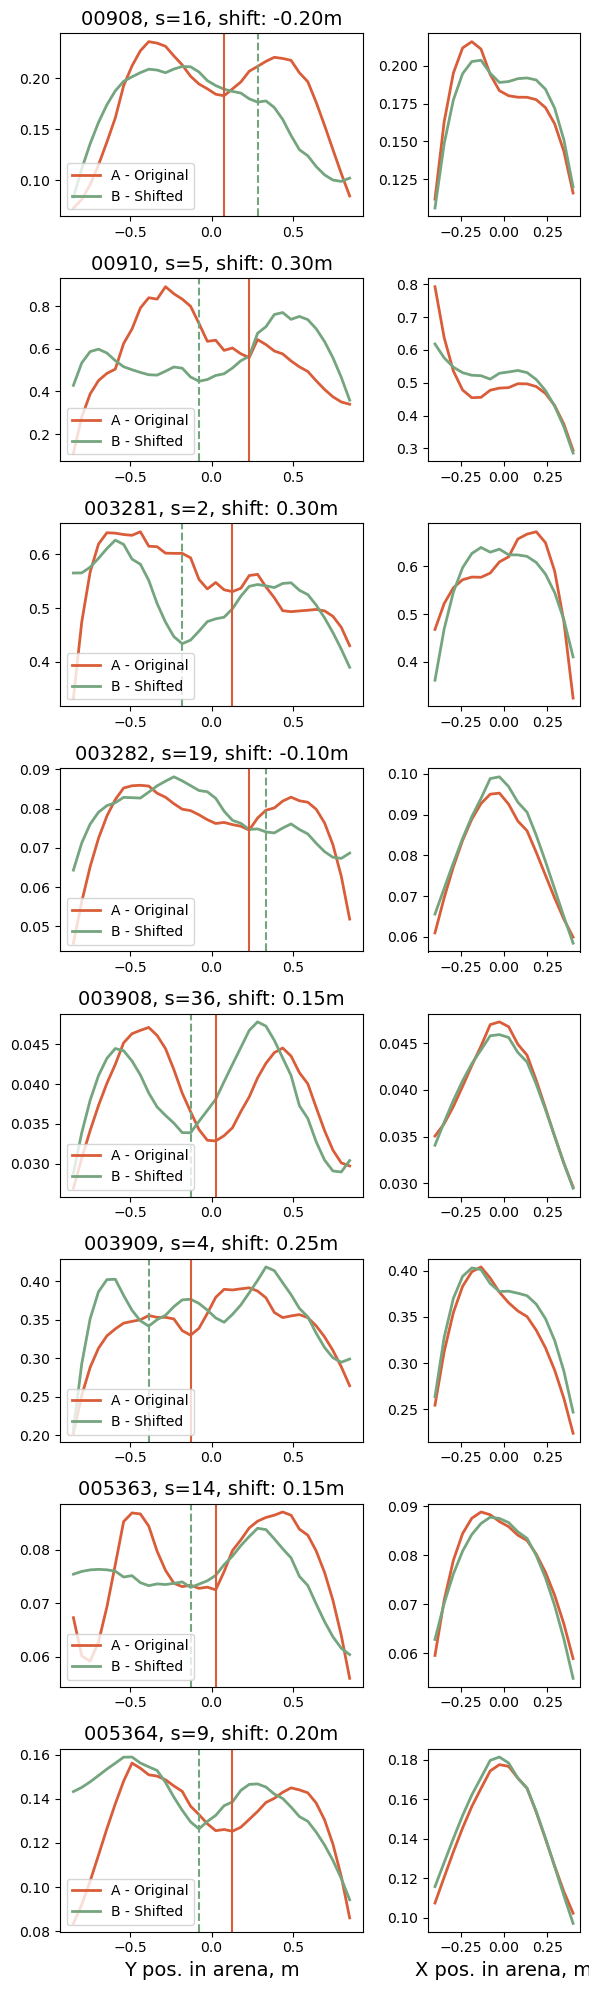

In [199]:
# for 003281 early periodic were messy
early_per_filt = [x for x in early_per if x[0] != '003281']
s_animals = animals
#s_animals = ['003281', '003282', '003908', '003909', '005363', '005364']
#s_animals = ['005363', '005364']
#s_animals = ['00908', '00910', '003281', '003282']
s_list    = single + periodic + visual_s + early_per_filt
#s_list    = visual_s

# for occupancy
#window, polyorder = 13, 3  # Savitzky-Golay params 13 and 3 are the best
#leg_loc = 'upper left'

# for speed
# Savitzky-Golay params 12 and 3 are the best
# right margin -2
window, polyorder = 12, 3  
leg_loc = 'lower left'

labels   = ('A - Original', 'B - Shifted')
x_labels = ('X pos. in arena, m', 'Y pos. in arena, m')
colors   = (COLORS['b'], COLORS['c'])

bin_size = 0.05  # in meters

rows, cols = len(s_animals), 2
wr = [1.6, 0.8]
hr = np.ones(rows)
gs_kw = dict(width_ratios=wr, height_ratios=hr)
fig, axes = plt.subplots(ncols=cols, nrows=rows, gridspec_kw=gs_kw, figsize=(6, 2.5*rows))

for i, animal in enumerate(s_animals):
    selected = [x for x in s_list if x[0] == animal]  
    conditions, occ_all_ps, speed_all_ps, extent, limits = get_occ_and_speed(selected, bin_size=bin_size)  
    
    var = speed_all_ps.copy()
    x_A = var['A'].mean(axis=1)
    x_B = var['B'].mean(axis=1)
    y_A = var['A'][:int(var['A'].shape[0]/3)].mean(axis=0)
    y_B = var['B'][:int(var['B'].shape[0]/3)].mean(axis=0)

    x_X = np.linspace(extent[0], extent[1], len(x_A))
    x_Y = np.linspace(extent[2], extent[3], len(y_A))

    # smooth using Savitzky-Golay (a bit better)
    x_Af = savgol_filter(x_A, window, polyorder)
    x_Bf = savgol_filter(x_B, window, polyorder)
    y_Af = savgol_filter(y_A, window, polyorder)
    y_Bf = savgol_filter(y_B, window, polyorder)

    margin = int(len(y_Bf)/4)
    max_A = margin + np.argmin(y_Af[margin:-margin-2])
    max_B = margin + np.argmin(y_Bf[margin:-margin-2])

    # Y-position
    ax = axes[i][0]
    ax.plot(x_Y, y_Af, label=labels[0], color=colors[0], lw=2)
    ax.plot(x_Y, y_Bf, label=labels[1], color=colors[1], lw=2)
    ax.axvline(x_Y[max_A], color=colors[0])
    ax.axvline(x_Y[max_B], color=colors[1], ls='--')
    ax.set_title("%s, s=%d, shift: %.2fm" % (animal, len(selected), (max_A - max_B)*bin_size), fontsize=14)
    ax.legend(loc=leg_loc)

    ax = axes[i][1]
    ax.plot(x_X, x_Af, color=colors[0], lw=2)
    ax.plot(x_X, x_Bf, color=colors[1], lw=2)

    if i == len(s_animals) - 1:
        axes[i][0].set_xlabel(x_labels[1], fontsize=14)
        axes[i][1].set_xlabel(x_labels[0], fontsize=14)
fig.tight_layout()

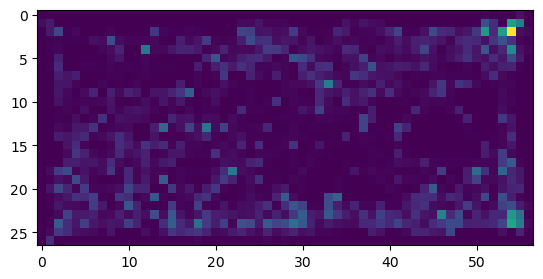

In [35]:
plt.imshow(occ_all_ps['B'])